In [0]:
!pip install kaggle --upgrade

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [0]:
!kaggle competitions download -c pubg-finish-placement-prediction

 53% 9.00M/16.9M [00:00<00:00, 31.4MB/s]
100% 16.9M/16.9M [00:00<00:00, 48.2MB/s]
 92% 90.0M/98.3M [00:00<00:00, 99.5MB/s]
100% 98.3M/98.3M [00:00<00:00, 126MB/s] 
100% 239M/239M [00:02<00:00, 88.4MB/s]
100% 239M/239M [00:02<00:00, 96.1MB/s]


In [0]:
!unzip train_V2.csv.zip 

Archive:  train_V2.csv.zip
replace train_V2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:

!unzip sample_submission_V2.csv.zip 

Archive:  sample_submission_V2.csv.zip
  inflating: sample_submission_V2.csv  


In [0]:
!unzip test_V2.csv.zip


Archive:  test_V2.csv.zip
  inflating: test_V2.csv             


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# **Exploring the training Data.**

In [0]:
data = pd.read_csv("train_V2.csv")

In [0]:
data.head()

Id         groupId  ... winPoints  winPlacePerc
0  7f96b2f878858a  4d4b580de459be  ...      1466        0.4444
1  eef90569b9d03c  684d5656442f9e  ...         0        0.6400
2  1eaf90ac73de72  6a4a42c3245a74  ...         0        0.7755
3  4616d365dd2853  a930a9c79cd721  ...         0        0.1667
4  315c96c26c9aac  de04010b3458dd  ...         0        0.1875

[5 rows x 29 columns]

In [0]:
# Removing the the features which are not required
train_data=data.iloc[:,3:]


In [0]:
del data

In [0]:
train_data.head()

assists  boosts  damageDealt  ...  weaponsAcquired  winPoints  winPlacePerc
0        0       0         0.00  ...                1       1466        0.4444
1        0       0        91.47  ...                5          0        0.6400
2        1       0        68.00  ...                2          0        0.7755
3        0       0        32.90  ...                3          0        0.1667
4        0       0       100.00  ...                2          0        0.1875

[5 rows x 26 columns]

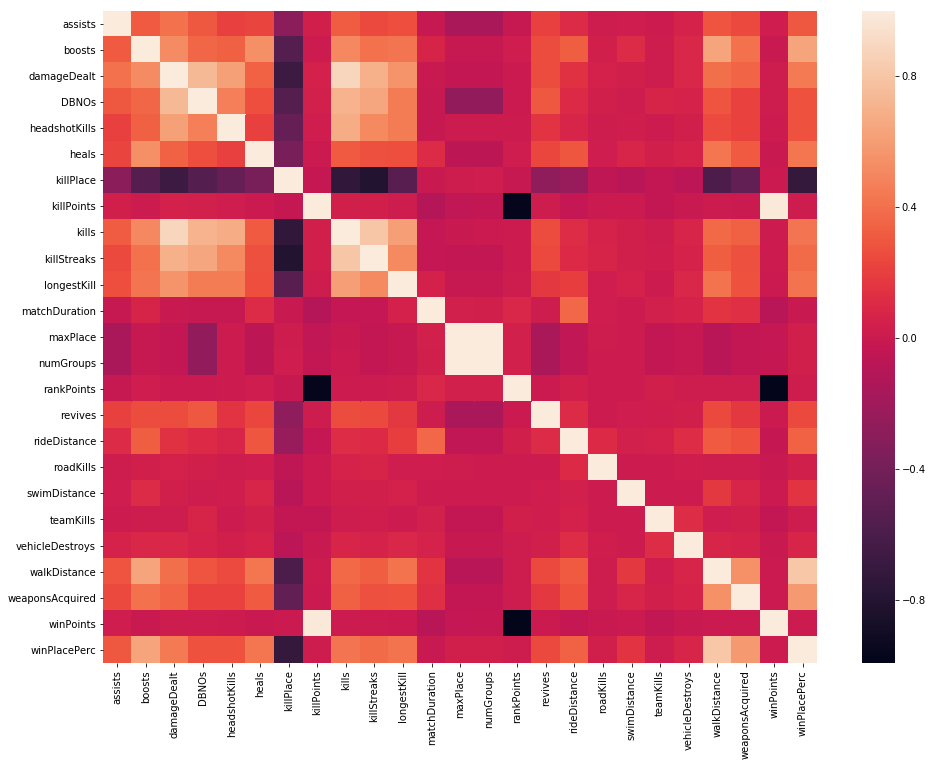

In [0]:
plt.figure(figsize=(16,12))
sb.heatmap(train_data.corr())

In [0]:
train_data.shape

(4446966, 26)

## Generating pair plots between the first 10000 examples

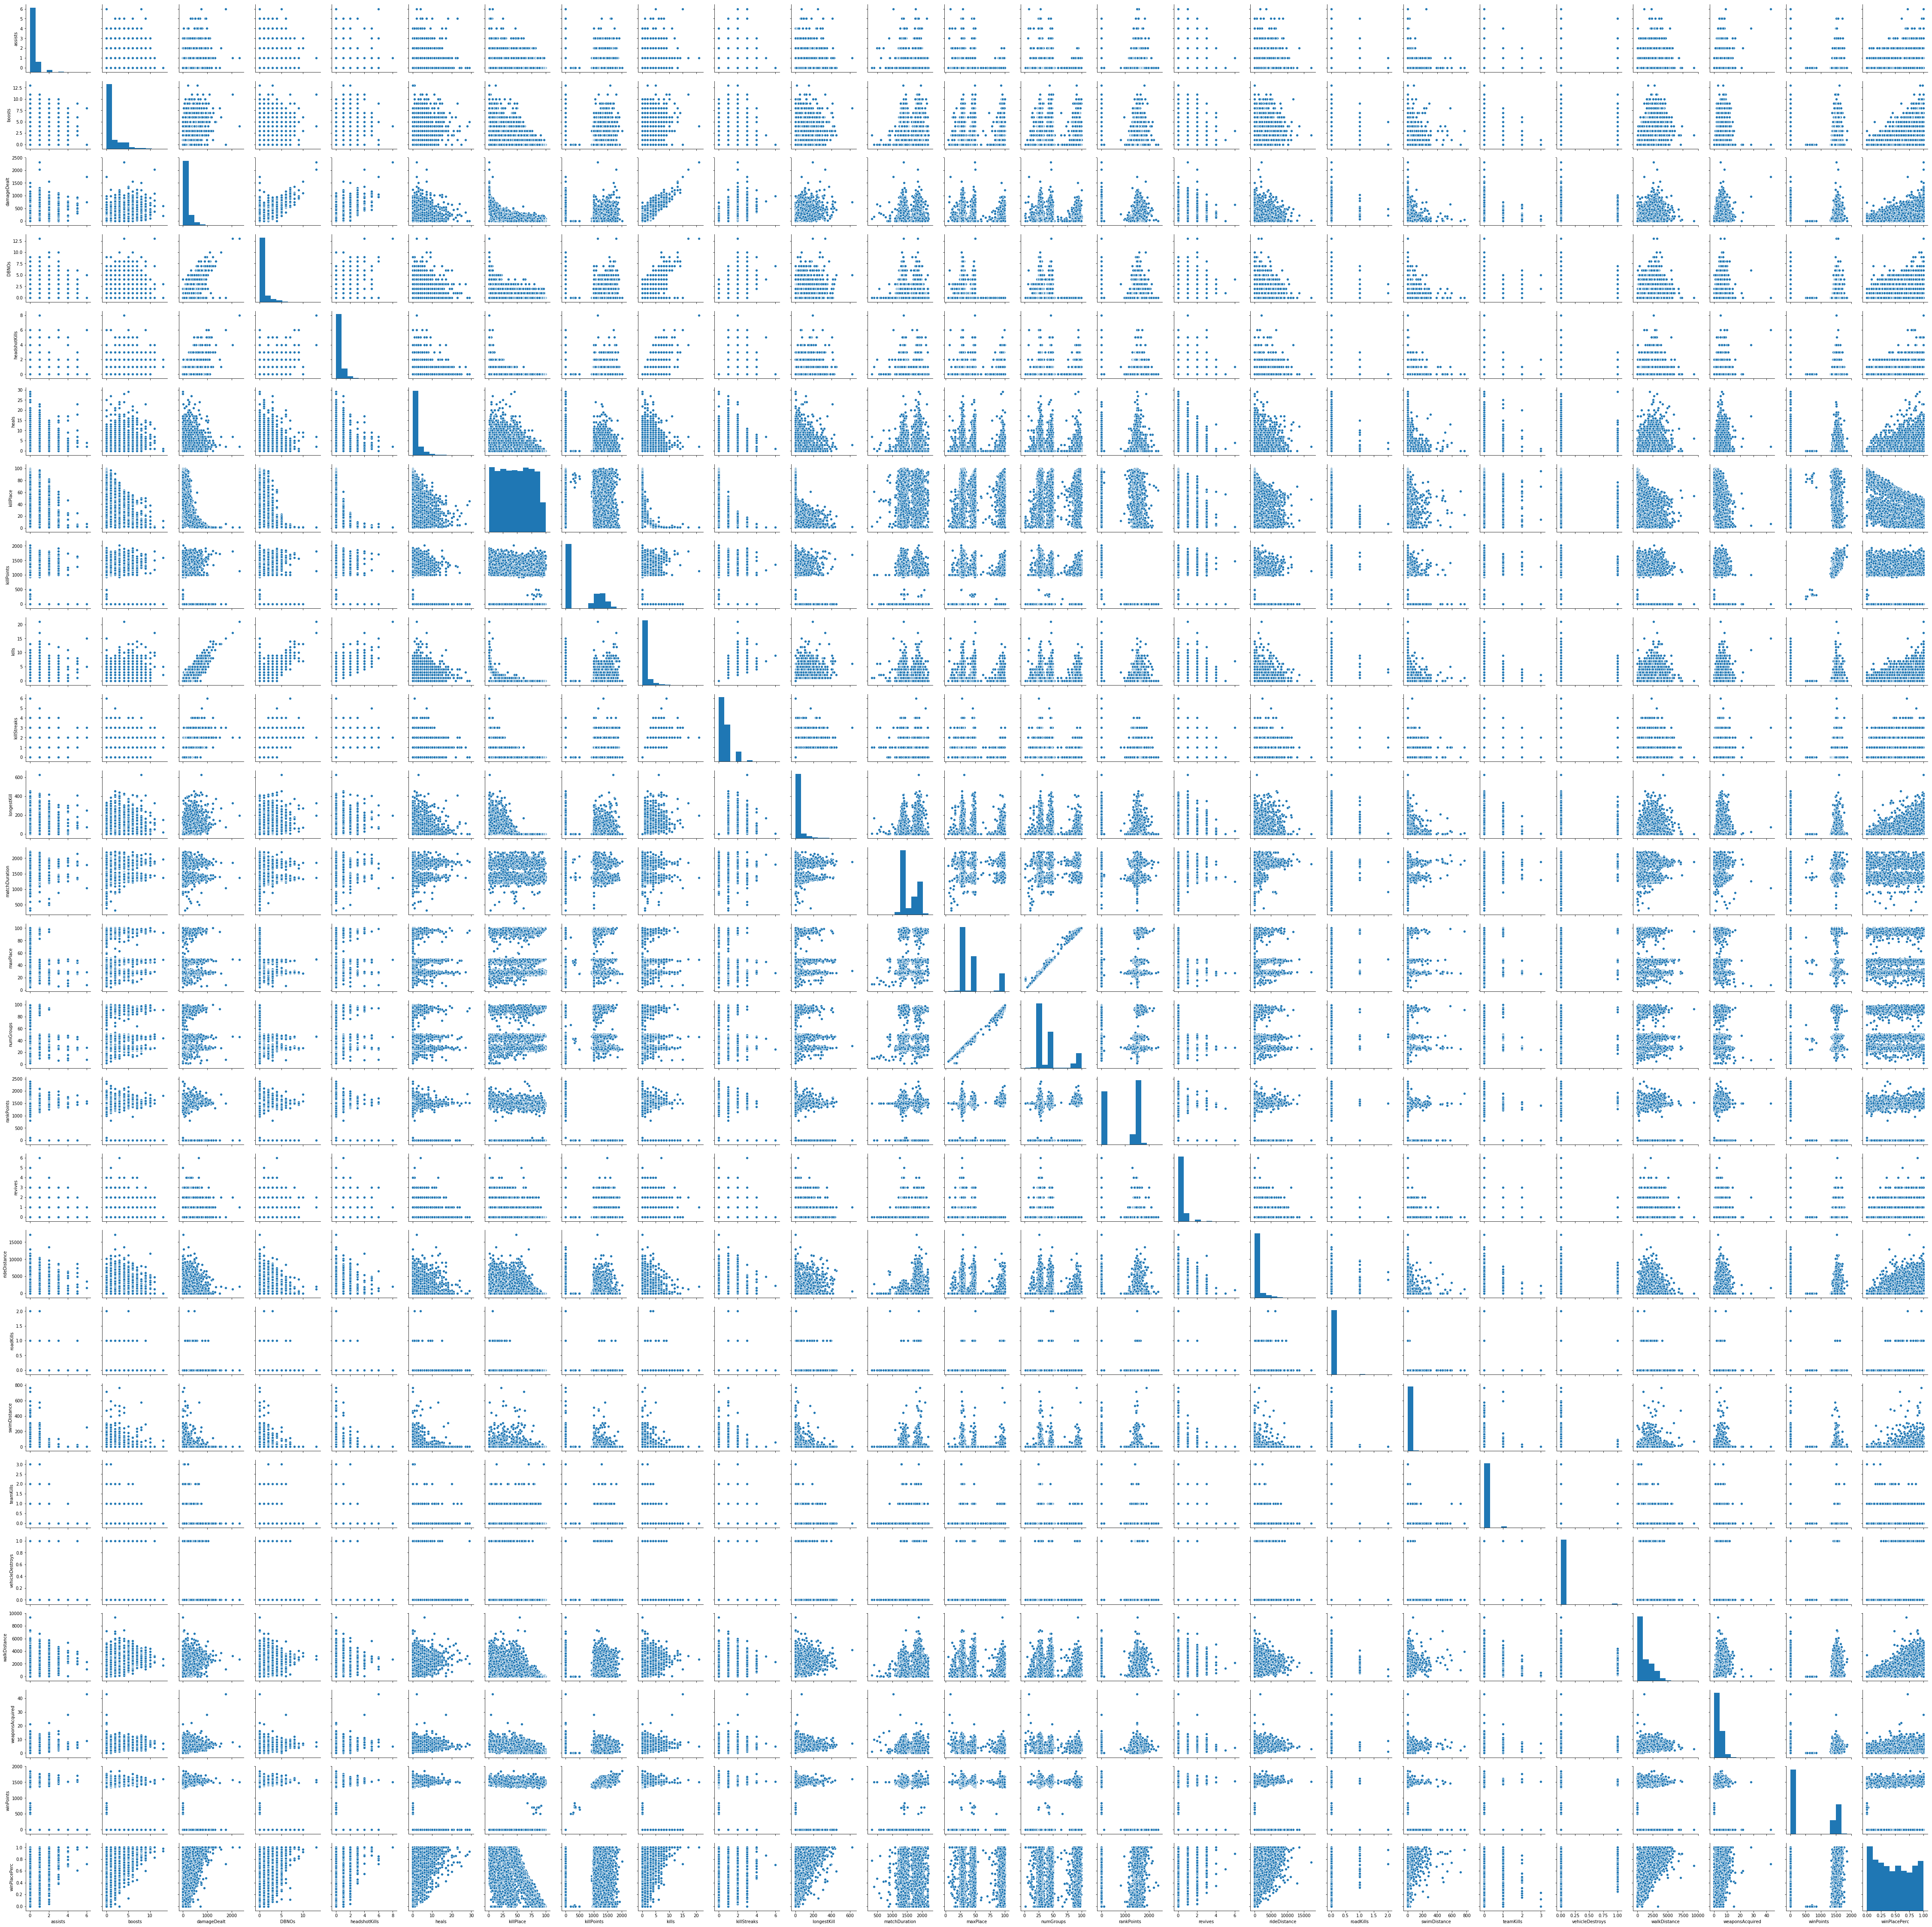

In [0]:
sb.pairplot(train_data.iloc[0:10000,:],kind="scatter")

## Encoding the match type data

In [0]:
from sklearn.preprocessing import LabelEncoder as LE
encoder = LE()
train_data["matchType"] = encoder.fit_transform(train_data["matchType"])

In [0]:
train_data.describe()

assists        boosts  ...     winPoints  winPlacePerc
count  4.446966e+06  4.446966e+06  ...  4.446966e+06  4.446965e+06
mean   2.338149e-01  1.106908e+00  ...  6.064601e+02  4.728216e-01
std    5.885731e-01  1.715794e+00  ...  7.397004e+02  3.074050e-01
min    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  ...  0.000000e+00  2.000000e-01
50%    0.000000e+00  0.000000e+00  ...  0.000000e+00  4.583000e-01
75%    0.000000e+00  2.000000e+00  ...  1.495000e+03  7.407000e-01
max    2.200000e+01  3.300000e+01  ...  2.013000e+03  1.000000e+00

[8 rows x 26 columns]

In [0]:
# Splitting the features and lables 

X_train = train_data.iloc[:,0:25]
X_train.head()
Y_train = train_data.iloc[:,25:]

## Dividing the data into training and validation dataset

In [0]:
from sklearn.model_selection import train_test_split
x1,x2,y1,y2 = train_test_split(X_train,Y_train,test_size=0.20)

# Building the DNN model using keras

---



In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import BatchNormalization


## Sequential neural network model(Feed Forward NN) is used

In [0]:
model = Sequential()

## The DNN is made up of 5 layers with 4 in between batch normalization layer 
1. Input layer with 32 units
2. Hidden layer with 64 units
3. Hidden layer with 64 units
4. Hidden layer with 64 units
5. Output layer with 1 units

Input layer and all the 3 hidden layers uses the relu activation function
The output layers uses sigmoid function as activation fucntion.
<a href="https://ibb.co/k45KkjW"><img src="https://i.ibb.co/7njv8P6/Pubg-DNN.png" alt="Pubg-DNN" border="0"></a>

In [0]:
model.add(Dense(32,input_dim=x1.shape[1],activation ="relu"))
model.add(BatchNormalization())
model.add(Dense(64,activation ="relu"))
model.add(BatchNormalization())
model.add(Dense(64,activation ="relu"))
model.add(BatchNormalization())
model.add(Dense(64,activation ="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation ="sigmoid"))

Optimizer (Cost Minimization Alg) is Adam

In [0]:
opt = Adam(lr=0.01)
model.compile(opt,loss='mse', metrics=['mae'])

In [0]:
model.fit(x1,y1,validation_data=(x2,y2),epochs=20,batch_size=10000)

Train on 3557572 samples, validate on 889394 samples
Epoch 1/20
3557572/3557572 [==============================] - 10s 3us/step - loss: 0.0149 - mean_absolute_error: 0.0870 - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
3557572/3557572 [==============================] - 8s 2us/step - loss: 0.0094 - mean_absolute_error: 0.0692 - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/20
3557572/3557572 [==============================] - 8s 2us/step - loss: 0.0085 - mean_absolute_error: 0.0660 - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/20
3557572/3557572 [==============================] - 8s 2us/step - loss: 0.0077 - mean_absolute_error: 0.0630 - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/20
3557572/3557572 [==============================] - 8s 2us/step - loss: 0.0073 - mean_absolute_error: 0.0613 - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/20
3557572/3557572 [==============================] - 8s 2us/step - loss: 0.0072 - mean_absolute_error: 0.06

In [0]:
# Test Data Set
x_test = pd.read_csv("test_V2.csv")
x_test=x_test.iloc[:,3:]
x_test["matchType"] = encoder.fit_transform(x_test["matchType"])

In [0]:
x_test.head()

assists  boosts  damageDealt  ...  walkDistance  weaponsAcquired  winPoints
0        0       0        51.46  ...         588.0                1          0
1        0       4       179.10  ...        2017.0                6          0
2        1       0        23.40  ...         787.8                4          0
3        0       0        65.52  ...        1812.0                3          0
4        0       4       330.20  ...        2963.0                4          0

[5 rows x 25 columns]

In [0]:
y_test = model.predict(x_test)

In [0]:
y_test

array([[0.21828967],
       [0.9614179 ],
       [0.70576227],
       ...,
       [0.86933213],
       [0.85098976],
       [0.04218199]], dtype=float32)